In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set( stopwords.words('english'))
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import string
import vaderSentiment
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import nltk
from nltk.stem import WordNetLemmatizer

# Load the English language model
nlp = spacy.load("en_core_web_md")

In [4]:
#Reading the Austin restaurant review file

Chicago_reviews = pd.read_csv('Dataset_2_Full.csv')
Chicago_reviews = Chicago_reviews[['Restaurant', 'Comments']]
Chicago_reviews

,Restaurant,Comments
0,Girl & The Goat,"Delicious food, friendly staff, and fun theme...."
1,Girl & The Goat,We were visiting Chicago and made a reservatio...
2,Girl & The Goat,Even though Girl & The Goat is one of those re...
3,Girl & The Goat,Yum yum yum yum yum! I can see why the reviews...
4,Girl & The Goat,The GOAT of the goat in Chicago.\n\nI'd waited...
...,...,...
111888,Labriola Chicago,Made reservations via Opentable weeks in advan...
111889,Labriola Chicago,Happy hour! Two words: free bread. What more c...
111890,Labriola Chicago,Labriola is actually a legit place to grab piz...
111891,Labriola Chicago,"My husband and I stopped here for pizza, it wa..."


In [6]:
# Creating a function to remove stopwords and punctuations

def clean_review(text):
    # Removing punctuations
    text = text.translate(str.maketrans('', '', string.punctuation)).lower().replace('\n', ' ')
    # Removing stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    lemmatized_text = ' '.join(lemmatized_words)
    
    return lemmatized_text

In [7]:
Chicago_reviews['cleaned_review'] = Chicago_reviews['Comments'].map(clean_review)
Chicago_reviews['cleaned_review'][0]

'delicious food friendly staff fun theme youre lucky youll meet owner nice lady ton personality always get cheesecake nacho come'

In [9]:
# Group by 'Restaurant' and aggregate 'cleaned_review' as combined text
Restaurant_Level_Agg_Comments = Chicago_reviews.groupby('Restaurant')['cleaned_review'].apply(lambda x: ' '.join(x)).reset_index()

# Rename the columns
Restaurant_Level_Agg_Comments.columns = ['Restaurant', 'Combined_Reviews']

Restaurant_Level_Agg_Comments['Num_Reviews'] = Chicago_reviews.groupby('Restaurant')['cleaned_review'].count().reset_index()['cleaned_review']

Restaurant_Level_Agg_Comments

,Restaurant,Combined_Reviews,Num_Reviews
0,3 Arts Club Cafe,came celebrate special occasion group friend 3...,510
1,AO Hawaiian Hideout,excellent food excellent drink pad see ewe awe...,517
2,Aba,came visiting chicago recommendation one best ...,504
3,Acanto,came lunch today impressed outdoor seating sup...,506
4,Ada Street,restaurant tucked away bunch warehouse dont pa...,517
...,...,...,...
233,Xoco,stopped quick weekday lunch small lively joint...,522
234,Yuzu Sushi & Robata Grill,love food beer best sushi place ever everythin...,513
235,etta - Bucktown,staple eating food never disappoints drink sim...,518
236,etta - River North,went last minute dinner city easy get reservat...,510


In [10]:
Restaurant_Level_Agg_Comments.set_index('Restaurant', inplace=True)

In [11]:
Restaurant_Level_Agg_Comments

,Combined_Reviews,Num_Reviews
Restaurant,,
3 Arts Club Cafe,came celebrate special occasion group friend 3...,510
AO Hawaiian Hideout,excellent food excellent drink pad see ewe awe...,517
Aba,came visiting chicago recommendation one best ...,504
Acanto,came lunch today impressed outdoor seating sup...,506
Ada Street,restaurant tucked away bunch warehouse dont pa...,517
...,...,...
Xoco,stopped quick weekday lunch small lively joint...,522
Yuzu Sushi & Robata Grill,love food beer best sushi place ever everythin...,513
etta - Bucktown,staple eating food never disappoints drink sim...,518


In [12]:
import nltk
from nltk import pos_tag
from collections import Counter

# Function to generate list of top 100 nouns for each restaurant

def noun_list_comment(text):
    word_pos_1 = pos_tag(text.split())
    list_of_unique_nouns = list(set([word for word, pos in word_pos_1 if (pos.startswith('N'))]))
    return list_of_unique_nouns

In [15]:
def noun_list_restaurant(Restaurant):
    Filtered_comments = Chicago_reviews[Chicago_reviews['Restaurant'] == Restaurant]['cleaned_review']
    list_of_all_nouns = Filtered_comments.map(noun_list_comment)
    Combined_list_of_nouns = []
    for list in list_of_all_nouns:
        Combined_list_of_nouns = Combined_list_of_nouns+list
    Combined_list_of_nouns = [x for x in Combined_list_of_nouns if x not in Restaurant.lower().split()]
    Noun_Counts = Counter(Combined_list_of_nouns)
    Noun_Counts_Dict = dict(Noun_Counts)
    return Noun_Counts_Dict

In [16]:
#Generating noun list for all restaurants

Restaurant_Level_Agg_Comments['Noun_List'] = Restaurant_Level_Agg_Comments.index.map(noun_list_restaurant)

In [20]:
Restaurant_Level_Agg_Comments

,Combined_Reviews,Num_Reviews,Noun_List
Restaurant,,,
3 Arts Club Cafe,came celebrate special occasion group friend 3...,510,"{'lobster': 50, 'roll': 77, 'disappoint': 7, '..."
AO Hawaiian Hideout,excellent food excellent drink pad see ewe awe...,517,"{'food': 307, 'drink': 88, 'glutenfree': 2, 's..."
Aba,came visiting chicago recommendation one best ...,504,"{'superb': 4, 'table': 27, 'dip': 47, 'hiccup'..."
Acanto,came lunch today impressed outdoor seating sup...,506,"{'mention': 6, 'size': 25, 'light': 13, 'porti..."
Ada Street,restaurant tucked away bunch warehouse dont pa...,517,"{'steak': 75, 'crunch': 6, 'uber': 4, 'chili':..."
...,...,...,...
Xoco,stopped quick weekday lunch small lively joint...,522,"{'mention': 3, 'price': 56, 'fork': 1, 'menu':..."
Yuzu Sushi & Robata Grill,love food beer best sushi place ever everythin...,513,"{'beer': 20, 'food': 206, 'year': 29, 'place':..."
etta - Bucktown,staple eating food never disappoints drink sim...,518,"{'instance': 2, 'watch': 2, 'everything': 98, ..."


In [21]:
Final_Vector_Austin = pd.read_csv('Final_Vector_df.csv')

In [59]:
Final_Vector_Austin.set_index('Restaurant', inplace = True)

In [23]:
#Creating a function to calculate lift for a restaurant, word pair

def calculate_lift(word, restaurant):
    num_a = sum(Nouns.get(word, 0) for Nouns in Restaurant_Level_Agg_Comments['Noun_List'])
    if word in Restaurant_Level_Agg_Comments.loc[restaurant, 'Noun_List'].keys():
        num_a_b = Restaurant_Level_Agg_Comments.loc[restaurant, 'Noun_List'][word]
    else:
        num_a_b = 0
    num_b = Restaurant_Level_Agg_Comments.loc[restaurant, 'Num_Reviews']
    n = sum(Restaurant_Level_Agg_Comments['Num_Reviews'])
    if num_a == 0:
        Lift = 0
    else:
        Lift = float(n)*num_a_b/(num_a*num_b)
    return Lift

In [26]:
# Creating a lift dataframe for all restaurants and all top attributes

lift_df = pd.DataFrame(index=Restaurant_Level_Agg_Comments.index, columns=Final_Vector_Austin.columns)

for row_index in lift_df.index:
    for col_name in lift_df.columns:
        lift_df.at[row_index, col_name] = calculate_lift(col_name, row_index)

In [27]:
lift_df

,Restaurant,cheesesteak,con,polenta,student,lemonade,poke,torchys,royale,pesto,...,skip,crowd,ipa,curry,commodore,chago,scratch,matzo,zha,rotisserie
Restaurant,,,,,,,,,,,,,,,,,,,,,
3 Arts Club Cafe,0,0.0,0.737472,0.0,0.0,1.875197,0.0,0.0,0.0,0.0,...,1.125118,0.717769,0.0,0.0,0.0,0,0.0,0.0,0,1.70076
AO Hawaiian Hideout,0,0.0,0.727487,0.0,0.0,0.0,16.161791,0.0,0.0,0.389258,...,0.369961,0.236017,0.0,10.240174,0.0,0,0.0,0.0,0,0.0
Aba,0,0.0,0.0,0.0,0.0,1.897521,0.0,0.0,0.0,0.0,...,2.277025,0.242105,0.0,0.0,0.0,0,0.0,0.0,0,0.0
Acanto,0,0.0,0.743302,5.025737,2.696737,1.890021,0.0,0.0,0.0,2.784041,...,1.134012,1.205738,1.504302,0.0,0.0,0,1.625974,0.0,0,1.714205
Ada Street,0,0.0,0.727487,26.780166,2.639359,0.0,0.0,0.0,0.0,2.724806,...,1.479846,1.416101,4.416887,0.553523,0.0,0,1.591378,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xoco,0,0.0,1.441038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.564925,0.935025,0.0,0.0,0.0,0,0.0,0.0,0,0.0
Yuzu Sushi & Robata Grill,0,0.0,1.466319,0.0,2.659939,0.0,6.373491,0.0,0.0,0.0,...,1.118539,0.475714,0.0,0.0,0.0,0,0.0,0.0,0,0.0
etta - Bucktown,0,0.0,0.726083,0.0,2.634264,0.0,0.0,0.0,0.0,0.0,...,2.584731,1.177806,0.0,0.552454,0.0,0,0.0,0.0,0,0.0


In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download NLTK's VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vgupt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:
#Calculating sentiment scores of all comments

Chicago_reviews['Sentiment'] = Chicago_reviews['cleaned_review']

sia = SentimentIntensityAnalyzer()

for i in range(len(Chicago_reviews)):
    
    # Perform sentiment analysis using VADER
    sentiment = sia.polarity_scores(Chicago_reviews['cleaned_review'][i])
    
    Chicago_reviews['Sentiment'][i] = sentiment['compound']

In [31]:
Chicago_reviews

,Restaurant,Comments,cleaned_review,Sentiment
0,Girl & The Goat,"Delicious food, friendly staff, and fun theme....",delicious food friendly staff fun theme youre ...,0.9413
1,Girl & The Goat,We were visiting Chicago and made a reservatio...,visiting chicago made reservation soon availab...,0.9968
2,Girl & The Goat,Even though Girl & The Goat is one of those re...,even though girl goat one restaurant hype 2014...,0.9881
3,Girl & The Goat,Yum yum yum yum yum! I can see why the reviews...,yum yum yum yum yum see review high plentiful ...,0.9883
4,Girl & The Goat,The GOAT of the goat in Chicago.\n\nI'd waited...,goat goat chicago id waited 7 year finally com...,0.9884
...,...,...,...,...
111888,Labriola Chicago,Made reservations via Opentable weeks in advan...,made reservation via opentable week advance tr...,0.9883
111889,Labriola Chicago,Happy hour! Two words: free bread. What more c...,happy hour two word free bread ask 5 wine choi...,0.9442
111890,Labriola Chicago,Labriola is actually a legit place to grab piz...,labriola actually legit place grab pizza youre...,0.9726
111891,Labriola Chicago,"My husband and I stopped here for pizza, it wa...",husband stopped pizza awesome came back next n...,0.9878


In [33]:
def res_word_sentiment(res, word):
    res_reviews = Chicago_reviews[Chicago_reviews['Restaurant']== res][['cleaned_review', 'Sentiment']].reset_index()
    if lift_df.loc[res, word] == 0:
        senti = 0
    else:
        senti_list = res_reviews[res_reviews['cleaned_review'].str.contains(word, case=False)]['Sentiment']
        senti = sum(senti_list)/len(senti_list)
    return senti

In [34]:
# Creating a sentiment dataframe for all restaurants and all top attributes

Sentiment_df = pd.DataFrame(index=Restaurant_Level_Agg_Comments.index, columns=Final_Vector_Austin.columns)

for row_index in Sentiment_df.index:
    print(row_index)
    for col_name in Sentiment_df.columns:

        Sentiment_df.at[row_index, col_name] = res_word_sentiment(row_index, col_name)

3 Arts Club Cafe
AO Hawaiian Hideout
Aba
Acanto
Ada Street
Adalina
Alinea
Alla Vita
Alpana
Amaru
Andros Taverna
Antico
Antique Taco
Apolonia
Arbella
Armitage Alehouse
Art Institute of Chicago
Au Cheval
Avec - Chicago
BITES Asian Kitchen + Bar
BLVD Steakhouse
Bandit
Bar Cargo
Bar Mar by José Andrés
Bar Siena
Barrio
Batter & Berries
Bavette’s Bar & Boeuf
Bazaar Meat by José Andrés
Beatnik West Town
Beatrix - River North
Beatrix - Streeterville
Big Star
Blue Door Kitchen & Garden
Boeufhaus
Boka
Brass Tack
Bryn Mawr Breakfast Club
CRĪO Bar and Restaurant
Cabra
Cafe Ba-Ba-Reeba!
Cafe Robey
Carnivale
Cebu
Cedar Palace
Centennial Crafted Beer & Eatery
Chef’s Special Cocktail Bar
Cherry Circle Room
Chicago Pizza And Oven Grinder Company
Chicago q
Ciccio Mio
Cindy’s Rooftop
Cira
Coalfire Pizza
Community Tavern
Crisp
Del Seoul
Dell Rooster - Chicago
Do-Rite Donuts & Chicken
Doc B’s Restaurant + Bar
Dove’s Luncheonette
Duck Duck Goat
Dusek’s Tavern & Dining Room
EL Ideas
EVER
Earls Kitchen + Bar


In [37]:
Sentiment_df

,Restaurant,cheesesteak,con,polenta,student,lemonade,poke,torchys,royale,pesto,...,skip,crowd,ipa,curry,commodore,chago,scratch,matzo,zha,rotisserie
Restaurant,,,,,,,,,,,,,,,,,,,,,
3 Arts Club Cafe,0,0,0.895647,0,0,0.972257,0,0,0,0,...,0.709175,0.816967,0,0,0,0,0,0,0,0.9932
AO Hawaiian Hideout,0,0,0.790243,0,0,0,0.887598,0,0,0.8689,...,0.8689,0.9871,0,0.918402,0,0,0,0,0,0
Aba,0,0,0,0,0,0.9383,0,0,0,0,...,0.901533,0.967712,0,0,0,0,0,0,0,0
Acanto,0,0,0.881357,0.832377,0.6808,0.9934,0,0,0,0.9091,...,0.33736,0.889544,0.963883,0,0,0,0.9485,0,0,0.9769
Ada Street,0,0,0.885334,0.978698,0.4404,0,0,0,0,0.9869,...,0.78834,0.978494,0.958525,0.995167,0,0,-0.0679,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xoco,0,0,0.828897,0,0,0,0,0,0,0,...,0.92722,0.85959,0,0,0,0,0,0,0,0
Yuzu Sushi & Robata Grill,0,0,0.922509,0,-0.9171,0,0.935023,0,0,0,...,0.7887,0.964944,0,0,0,0,0,0,0,0
etta - Bucktown,0,0,0.866909,0,0.9559,0,0,0,0,0,...,0.972422,0.949969,0,0.97285,0,0,0,0,0,0


In [38]:
# Calculating final evaluation score

Final_Vector_df = pd.DataFrame(index=Restaurant_Level_Agg_Comments.index, columns=Final_Vector_Austin.columns)

for row_index in Final_Vector_df.index:
    for col_name in Final_Vector_df.columns:
        Final_Vector_df.at[row_index, col_name] = lift_df.at[row_index, col_name]*Sentiment_df.at[row_index, col_name]

In [39]:
Final_Vector_df

,Restaurant,cheesesteak,con,polenta,student,lemonade,poke,torchys,royale,pesto,...,skip,crowd,ipa,curry,commodore,chago,scratch,matzo,zha,rotisserie
Restaurant,,,,,,,,,,,,,,,,,,,,,
3 Arts Club Cafe,0,0.0,0.660515,0.0,0.0,1.823174,0.0,0.0,0.0,0.0,...,0.797906,0.586393,0.0,0.0,0.0,0,0.0,0.0,0,1.689195
AO Hawaiian Hideout,0,0.0,0.574891,0.0,0.0,0.0,14.345169,0.0,0.0,0.338226,...,0.32146,0.232972,0.0,9.404596,0.0,0,0.0,0.0,0,0.0
Aba,0,0.0,0.0,0.0,0.0,1.780444,0.0,0.0,0.0,0.0,...,2.052814,0.234288,0.0,0.0,0.0,0,0.0,0.0,0,0.0
Acanto,0,0.0,0.655114,4.183307,1.835938,1.877546,0.0,0.0,0.0,2.530972,...,0.38257,1.072557,1.449972,0.0,0.0,0,1.542236,0.0,0,1.674607
Ada Street,0,0.0,0.644069,26.209706,1.162374,0.0,0.0,0.0,0.0,2.689111,...,1.166622,1.385647,4.233697,0.550848,0.0,0,-0.108055,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xoco,0,0.0,1.194471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.378249,0.803738,0.0,0.0,0.0,0,0.0,0.0,0,0.0
Yuzu Sushi & Robata Grill,0,0.0,1.352693,0.0,-2.43943,0.0,5.959359,0.0,0.0,0.0,...,0.882191,0.459038,0.0,0.0,0.0,0,0.0,0.0,0,0.0
etta - Bucktown,0,0.0,0.629448,0.0,2.518093,0.0,0.0,0.0,0.0,0.0,...,2.51345,1.11888,0.0,0.537455,0.0,0,0.0,0.0,0,0.0


In [75]:
from sklearn.metrics.pairwise import cosine_similarity as cs

# function to calculate cosine similarity for a pair of vectors

def cosine_sim(City1_res, City2_res):
    # Select one row from each DataFrame
    row1 = Final_Vector_Austin.loc[City1_res]
    row2 = Final_Vector_df.loc[City2_res]

    # Create a new DataFrame by concatenating the selected rows
    df = pd.concat([row1, row2], axis=1)
    df=df.T
    df=df.fillna(0)
    similarity = cs(df, df)[0,1]
    return similarity

In [76]:
cosine_sim('1618 Asian Fusion', '3 Arts Club Cafe')

0.04388553141676261

In [111]:
def top_3_match(Restaurant):
    sim_dict = {}
    for rest in Restaurant_Level_Agg_Comments.index[Restaurant_Level_Agg_Comments.index!=Restaurant]:
        similarity = cosine_sim(Restaurant, rest)
        sim_dict[rest] = similarity
        sorted_sim_dict = dict(sorted(sim_dict.items(), key=lambda item: item[1], reverse=True))
        # Number of elements to pick (e.g., 3)
        n = 5

        # Using a loop to pick the first n elements
        first_n_elements = {}
        for key, value in sorted_sim_dict.items():
            if len(first_n_elements) < n:
                first_n_elements[key] = value
            else:
                break
    return first_n_elements

In [112]:
top_3_match('Qi Austin')

{'Chicago q': 0.4269881548858201,
 'MingHin Cuisine': 0.4064504396314827,
 'The Duck Inn': 0.38686490965963133,
 'Duck Duck Goat': 0.21956929328871883,
 'Shanghai Terrace': 0.1678438408206699}

In [113]:
# Select one row from each DataFrame
row1 = Final_Vector_Austin.loc['Qi Austin']
row2 = Final_Vector_df.loc['Duck Duck Goat']

# Create a new DataFrame by concatenating the selected rows
df = pd.concat([row1, row2], axis=1)

In [114]:
df['diff'] = abs(df['Qi Austin']-df['Duck Duck Goat'])

In [119]:
df_for_wc = df.sort_values(by='Duck Duck Goat', ascending = False)[:50][['Qi Austin', 'Duck Duck Goat']].T

In [94]:
df_for_wc.loc[['Qi Austin']]

,alligator,caviar,mustard,vinegar,barbecue,sum,bbq,pickle,gold,platter,...,detail,corn,sweetness,shrimp,football,combo,chicken,office,ambience,art
Qi Austin,165.235217,24.833386,2.434927,3.623504,0.547484,62.133981,0.632656,0.565327,2.538815,2.089713,...,2.400026,0.742802,1.22179,4.680582,1.390023,1.641692,1.402512,3.213199,2.596902,0.927377


In [120]:
df_for_wc

,xiao,potstickers,sui,siu,mapo,moo,dan,bao,teach,scallion,...,mango,soup,z,soy,shallot,trader,po,bark,peanut,girl
Qi Austin,14.168993,42.333879,69.248515,15.63,2.271855,0.0,2.733404,22.846914,0.0,6.533254,...,3.509967,14.776297,0.0,3.609221,0.0,1.321784,0.865029,0.0,0.0,0.530097
Duck Duck Goat,157.964867,67.70862,67.106091,64.441061,52.404373,49.092046,31.451076,30.4945,25.275161,24.931714,...,5.864639,5.796608,5.793346,5.682602,5.480415,5.355341,5.050363,5.004848,4.85428,4.733887


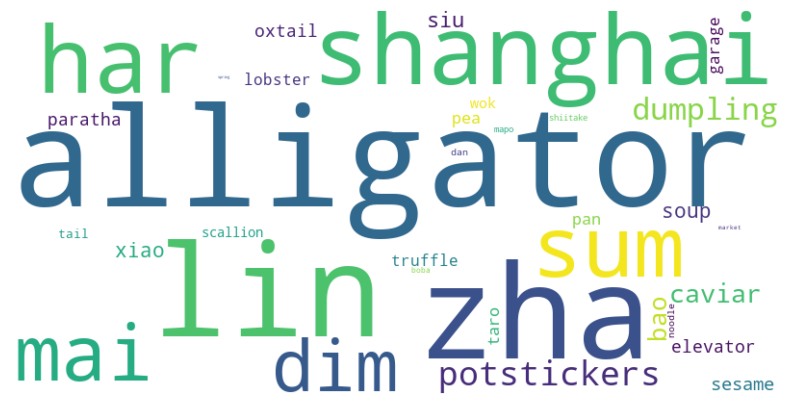

In [117]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a DataFrame with word frequencies (replace with your data)
word_freq_df = df_for_wc.loc[['Qi Austin']]

# Extract the frequencies and words from the DataFrame
frequencies = word_freq_df.iloc[0].tolist()
words = word_freq_df.columns.tolist()

# Create a dictionary where words are keys and frequencies are values
word_frequencies = dict(zip(words, frequencies))

# Create a WordCloud object with word frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

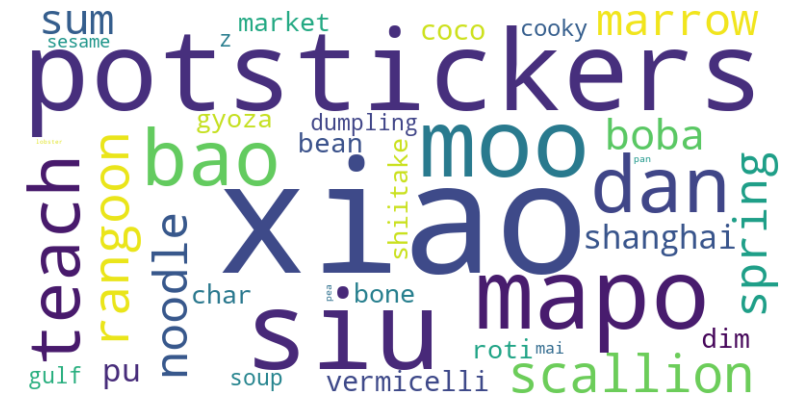

In [118]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a DataFrame with word frequencies (replace with your data)
word_freq_df = df_for_wc.loc[['Duck Duck Goat']]

# Extract the frequencies and words from the DataFrame
frequencies = word_freq_df.iloc[0].tolist()
words = word_freq_df.columns.tolist()

# Create a dictionary where words are keys and frequencies are values
word_frequencies = dict(zip(words, frequencies))

# Create a WordCloud object with word frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [103]:
Unique_Rest = pd.read_csv('chicago_topic_vectors.csv')

In [105]:
Unique_Rest = Unique_Rest['Restaurants']

Unique_Rest

0                               The Loyalist
1                            MingHin Cuisine
2                          MCCB Chicago 时尚食谱
3                                    Oiistar
4                           Shanghai Terrace
5                  Small Cheval- Wicker Park
6                               Ramen Wasabi
7                     Kizuki Ramen & Izakaya
8                                  RAMEN-SAN
9                             Duck Duck Goat
10               Chef’s Special Cocktail Bar
11                         Pequod’s Pizzeria
12                                 Au Cheval
13                 Qing Xiang Yuan Dumplings
14                    Lou Malnati’s Pizzeria
15                                Giordano’s
16                                   Mott St
17                                      Umai
18                                  Big Star
19                                     Smyth
20                            Takito Kitchen
21                              Antique Taco
22        

In [106]:
def top_3_match_unique(Restaurant):
    sim_dict = {}
    for rest in Unique_Rest:
        similarity = cosine_sim(Restaurant, rest)
        sim_dict[rest] = similarity
        sorted_sim_dict = dict(sorted(sim_dict.items(), key=lambda item: item[1], reverse=True))
        # Number of elements to pick (e.g., 3)
        n = 3

        # Using a loop to pick the first n elements
        first_n_elements = {}
        for key, value in sorted_sim_dict.items():
            if len(first_n_elements) < n:
                first_n_elements[key] = value
            else:
                break
    return first_n_elements

In [107]:
top_3_match_unique('Qi Austin')

{'MingHin Cuisine': 0.4064504396314827,
 'Duck Duck Goat': 0.21956929328871883,
 'Shanghai Terrace': 0.1678438408206699}

In [117]:
Restaurant_Level_Agg_Comments.to_csv('Restaurant_Level_Agg_Comments.csv')

In [121]:
Austin_reviews.to_csv('Austin_reviews_Clean.csv')